In [1]:
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad as quad
from tqdm import tqdm
import emcee

In [2]:
from astropy.table import Table

# Load the fits file
data = Table.read('StellarMassesv19.fits', format='fits')

#print (data.colnames)
filter_data = data[(data['logmstar'] + np.log10(data['fluxscale']) > 9) & (data['Z'] > 0.035) & (data['Z'] < 0.065) & (data['fluxscale'] > 0.3) & (data['fluxscale'] < 3)]

fluxscale = filter_data['fluxscale']
z = filter_data['Z']
logM = filter_data['logmstar']+np.log10(fluxscale)
dlogM = filter_data['dellogmstar']

C:\Users\catch\AppData\Local\Temp\ipykernel_15680\3744097893.py:7: RuntimeWarning: invalid value encountered in log10
  filter_data = data[(data['logmstar'] + np.log10(data['fluxscale']) > 9) & (data['Z'] > 0.035) & (data['Z'] < 0.065) & (data['fluxscale'] > 0.3) & (data['fluxscale'] < 3)]


In [8]:
from sympy import uppergamma, N

def comoving_volume(z_initial, z_final, H0=70, Omega_M=0.3, Omega_Lambda=0.7):
    c = 3e5 #light speed in km/s as H0 is 70km/s/MPc
    # For a flat universe, Omega_k = 0
    Omega_k = 1 - Omega_M - Omega_Lambda  
    # Hubble distance in Mpc
    DH = c / H0  

    # Angular size distance
    def E(z, Omega_M=Omega_M, Omega_Lambda=Omega_Lambda, Omega_k=Omega_k):
        return np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

    # Integral for comoving distance DC
    def comoving_distance(z):
        return quad(lambda z: 1/E(z), 0, z)[0] * DH

    # Calculate DC for initial and final redshifts
    DC_initial = comoving_distance(z_initial)
    DC_final = comoving_distance(z_final)

    # Volume of the light cone V_C using the formula for Omega_k = 0 (flat universe)
    VC_initial = (4 * np.pi / 3) * DC_initial**3
    VC_final = (4 * np.pi / 3) * DC_final**3

    # The volume covered between z_initial and z_final is the difference
    V_360 = VC_final - VC_initial
    
    #full sky has 41253 sq degrees and GAMA has 250sq degrees
    V_gama = 143/41253 * V_360
    
    return V_gama

# Initial and final redshifts
z_initial = 1e-6
z_final = 0.065

# Calculate and print the volume of the light cone
volume = comoving_volume(z_initial, z_final)
print(f"The volume of the light cone between z={z_initial} and z={z_final} is approximately {volume:.2f} cubic Mpc.")

def lnlike_2model(parvals, data, uncerts, return_model=False):
    alpha1, alpha2, log_m_star, log_phi_star1,log_phi_star2= parvals
    log_mass= data 
    #print(parvals)
    
    if log_m_star < 8 or log_m_star > 12 or alpha1 >= 2 or alpha2 >= 2 or log_phi_star1 <= -5 or log_phi_star1 <= -5:
        return -np.inf, 0
    
    def new_sch(): #data=logM
        x = 10**(data-log_m_star)
        sch1 = (10**log_phi_star1)*(x**(alpha1+1))
        sch2 = (10**log_phi_star2)*(x**(alpha2+1))
        return (sch1+sch2)*np.exp(-x)*np.log(10)
    
    def new_int():
        [a, b] = [min(log_mass) - log_m_star, max(log_mass) - log_m_star]

        # Compute uppergamma values using sympy's N to ensure numerical values
        gamma1_a = float(N(uppergamma(alpha1 + 1, 10**a)))
        gamma1_b = float(N(uppergamma(alpha1 + 1, 10**b)))
        gamma2_a = float(N(uppergamma(alpha2 + 1, 10**a)))
        gamma2_b = float(N(uppergamma(alpha2 + 1, 10**b)))

        norm1 = ((10**log_phi_star1) * (gamma1_a - gamma1_b))
        norm2 = ((10**log_phi_star2) * (gamma2_a - gamma2_b))
        norm = norm1 + norm2

        return(norm)
    
    def Nexp(parvals, data, z_initial=0.035, z_final=0.065):
        V=comoving_volume(z_initial,z_final)
        phi_int =  new_int()
        Nexp = V * phi_int
        return Nexp
    


    def pslike(parvals, data):
        #expected Number Counts

        #log Likelihood
        Nobs = len(z)
        Nexp1 = Nexp(parvals, data)
        logL =(-1./2.)*((Nobs-Nexp1)**2)/Nexp1 -(1./2.*np.log(2*np.pi*Nexp1))

        #print(logL, Nobs, Nexp1)
        return logL
    
    
    lnprior_alpha1 = -0.5 * ((-1 - alpha1) / 1.5) ** 2
    lnprior_alpha2 = -0.5 * ((-1 - alpha2) / 1.5) ** 2
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    lnprior = lnprior_alpha1 + lnprior_alpha2
    
    
    # Vectorized calculation of the Schechter function
    sch = new_sch()
    
    # Efficient integral computation
    norm = new_int()

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )

    P = pslike(parvals,data)

    Nexp1 = Nexp(parvals, data)

    if np.isnan(L) or np.isnan(P) or np.isinf(L) or np.isinf(P):
        #print(parvals, L, P)
        return -np.inf, 0
    
    if return_model:
        return like
    
    #print( L,P)
    return L + lnprior + P, Nexp1

The volume of the light cone between z=1e-06 and z=0.065 is approximately 300145.55 cubic Mpc.


In [9]:
[alpha1, alpha2] = [-1.47, -0.35]
[phi_star1, phi_star2] = [0.79e-3, 3.96e-3]
[log_phi_star1, log_phi_star2] = [np.log10(0.79e-3), np.log10(10**3.96e-3)]

log_m_star = 10.66

parvals = alpha1, alpha2, log_m_star, log_phi_star1, log_phi_star2
print(parvals)

(-1.47, -0.35, 10.66, -3.1023729087095586, 0.003959999999999978)


In [10]:
#define the parameters for emcee

ndim = 5 #m_star,alpha
nwalkers = 20 #>=2*ndim; the more the better but makes the code slow if too many

#define the initial position of the walkers
p0= np.random.rand(nwalkers, ndim) #we use random initial distribution
mstar00 = 10.5 + 0.5 * np.random.randn(nwalkers)
alpha00 = -1.5 + 0.3 * np.random.rand(nwalkers)
alpha01 = -0.5 + 0.3 * np.random.rand(nwalkers)
log_phistar00 = np.log10(0.8e-3 + 0.0003 * np.random.rand(nwalkers))
log_phistar01 = np.log10(3e-2 + 0.003 * np.random.rand(nwalkers))

p0=np.vstack([alpha00, alpha01,mstar00, log_phistar00, log_phistar01]).T

In [11]:
## initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike_2model, args=[logM,dlogM])


In [12]:
#run the sampler
state = sampler.run_mcmc(p0, 10000, progress=True)
#sampler.reset()
#state = sampler.run_mcmc(state.coords, 10000, progress=True)

100%|██████████| 10000/10000 [24:48<00:00,  6.72it/s]


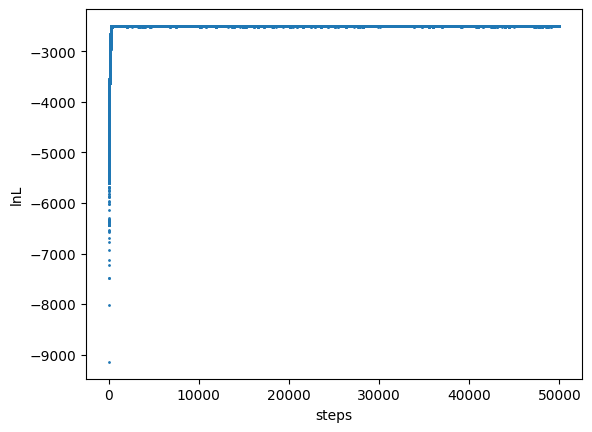

In [8]:
walker, step = np.indices( sampler.chain.shape[:2] )
plt.figure()
plt.scatter( step, sampler.lnprobability, 1)
plt.xlabel("steps")
plt.ylabel('lnL')
#plt.ylim([-2600,100])
plt.show()

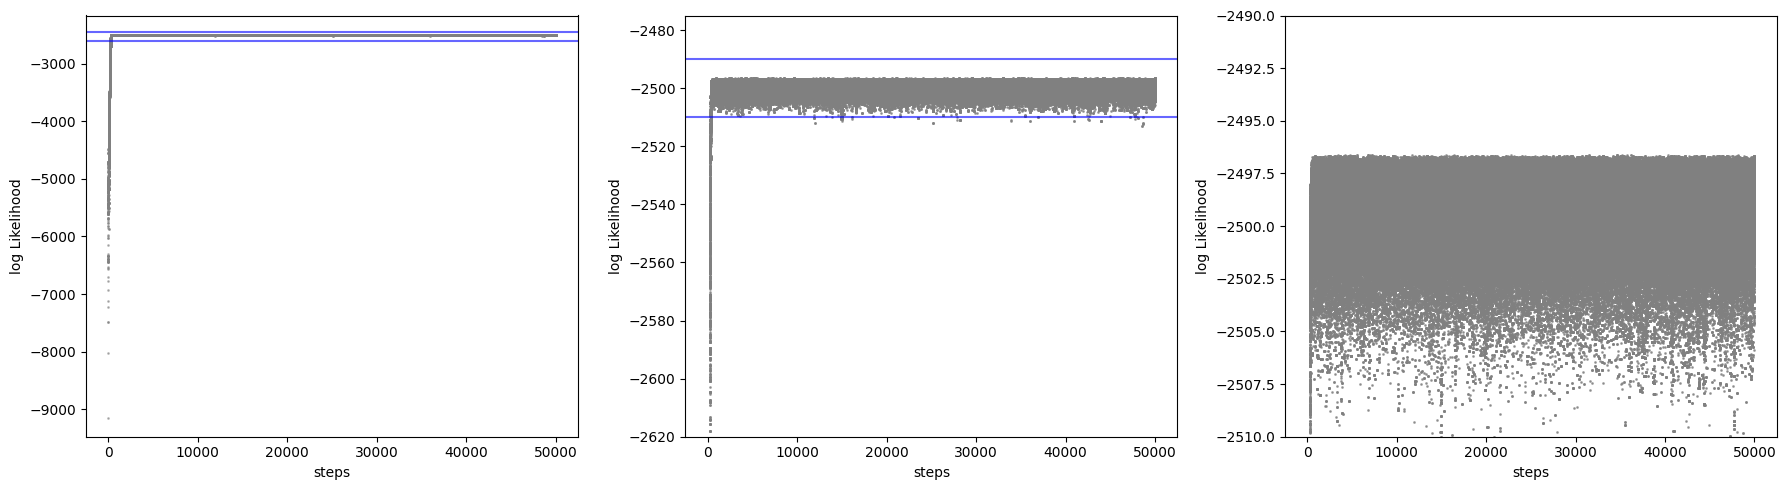

In [9]:
# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# First subplot: Parameter space plot (Example - you can replace it with any parameter plot)
walker, step = np.indices(sampler.chain.shape[:2])
axs[0].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.5)
axs[0].axhline(y = -2600, color = 'blue', linestyle = '-', alpha=0.6) 
axs[0].axhline(y = -2450, color = 'blue', linestyle = '-', alpha=0.6) 
axs[0].set_xlabel("steps")
axs[0].set_ylabel("log Likelihood")

# Second subplot: lnL plot
axs[1].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.7)
axs[1].axhline(y = -2510, color = 'blue', linestyle = '-', alpha=0.6) 
axs[1].axhline(y = -2490, color = 'blue', linestyle = '-', alpha=0.6)
axs[1].set_xlabel("steps")
axs[1].set_ylabel("log Likelihood")
axs[1].set_ylim([-2620, -2475])

# Third subplot: lnL plot
axs[2].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.7)
axs[2].set_xlabel("steps")
axs[2].set_ylabel("log Likelihood")
axs[2].set_ylim([-2510, -2490])

# Adjust layout
plt.tight_layout()
plt.show()

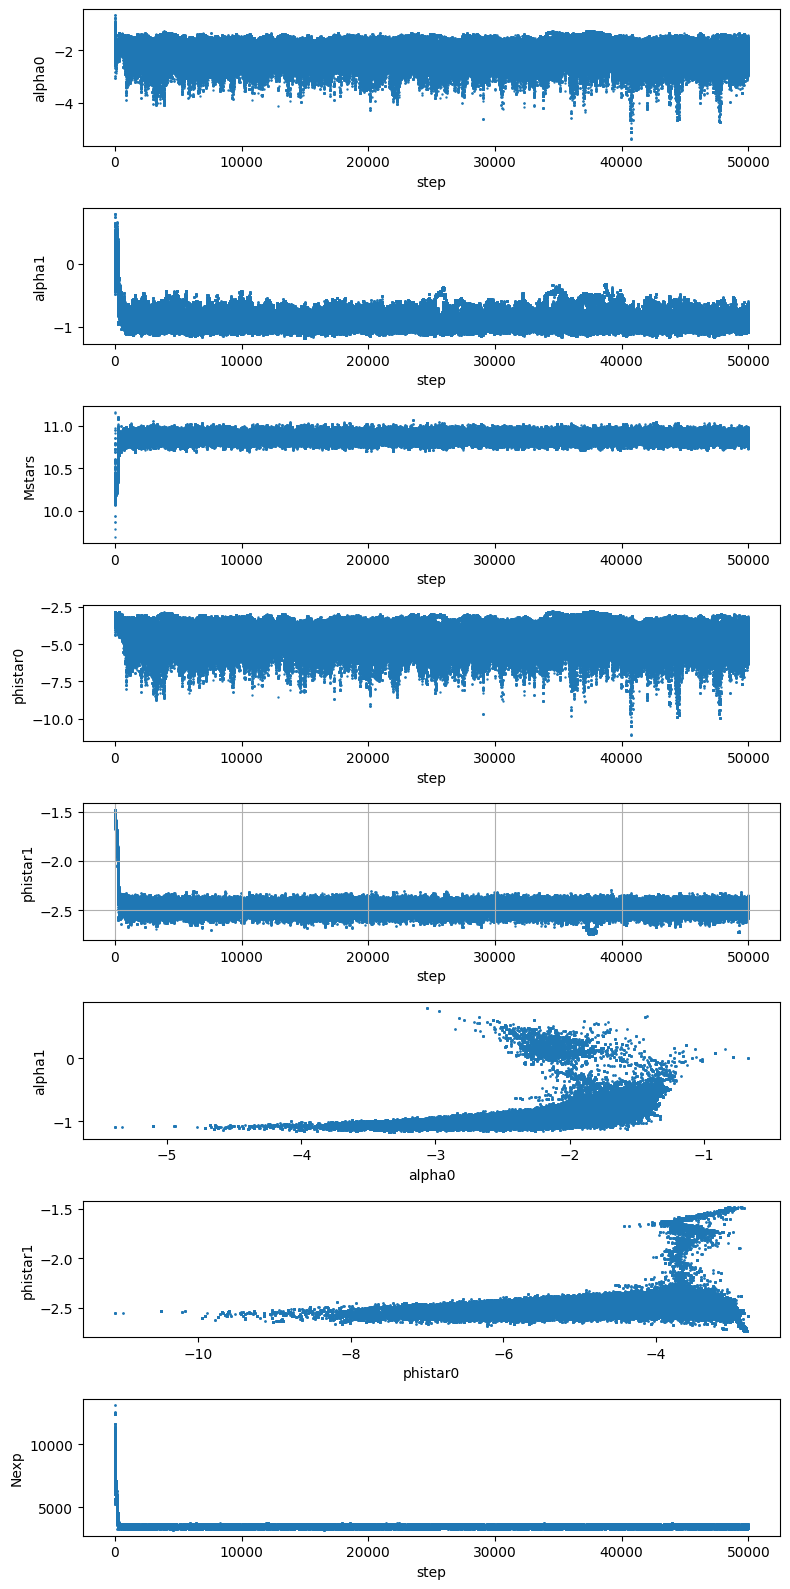

In [10]:
# Create the subplots
fig, axs = plt.subplots(8, 1, figsize=(8, 16))

# First subplot
axs[0].scatter(step, sampler.chain[..., 0], s=0.5)
axs[0].set_xlabel("step")
axs[0].set_ylabel("alpha0")

# Second subplot
walker, step = np.indices(sampler.chain.shape[:2])
axs[1].scatter(step, sampler.chain[..., 1], s=1)
axs[1].set_xlabel("step")
axs[1].set_ylabel("alpha1")

# Third subplot
axs[2].scatter(step, sampler.chain[..., 2], s=0.5)
axs[2].set_xlabel("step")
axs[2].set_ylabel("Mstars")

# Fourth subplot
axs[3].scatter(step, sampler.chain[..., 3], s=0.5)
axs[3].set_xlabel("step")
axs[3].set_ylabel("phistar0")

# Fifth subplot
axs[4].scatter(step, sampler.chain[..., 4], s=0.5)
axs[4].set_xlabel("step")
axs[4].set_ylabel("phistar1")
axs[4].grid()

# Sixth subplot
axs[5].scatter(sampler.chain[..., 0], sampler.chain[..., 1], s=1)
axs[5].set_xlabel("alpha0")
axs[5].set_ylabel("alpha1")

# Seventh subplot
axs[6].scatter(sampler.chain[..., 3], sampler.chain[..., 4], s=1)
axs[6].set_xlabel("phistar0")
axs[6].set_ylabel("phistar1")

# Eighth subplot
Nexp = sampler.get_blobs().T
axs[7].scatter(step, Nexp, s=1)
axs[7].set_xlabel("step")
axs[7].set_ylabel("Nexp")

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
print(np.argmax(Nexp[:,-1]))
print(np.argmax(sampler.lnprobability[:,-1]))

11
15


In [12]:
print(Nexp[:,-1])

[3518.93764681 3398.48541663 3514.17683341 3477.02719401 3477.52573148
 3495.59898966 3527.56752386 3478.13891083 3502.47175371 3523.18784854
 3520.0988612  3549.36728356 3463.45544322 3482.25031819 3394.70974093
 3441.12469045 3473.48241663 3418.68973467 3523.11772152 3442.81658064]


(20, 50000, 5)
[-1.45147171 -0.16577522 10.51346765 -3.12948863 -1.52120052]
[-2.13605647 -0.9254648  10.85906762 -4.57276111 -2.46829678]


(0.01, 1)

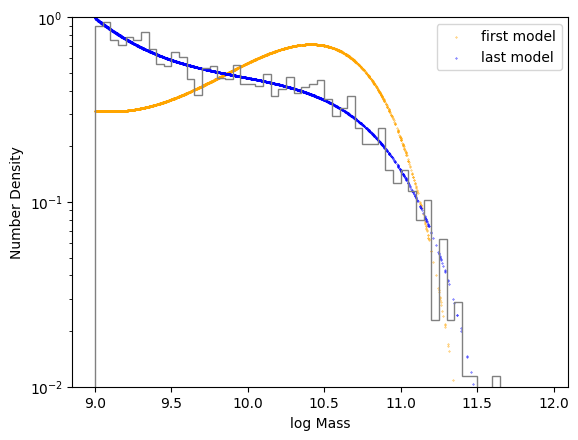

In [14]:
print( sampler.chain.shape )
print( sampler.chain[15,0] )
print( sampler.chain[15,-1] )

args=[logM,dlogM]

first_model = lnlike_2model( sampler.chain[ 15, 0 ], *args, return_model=True )
last_model = lnlike_2model( sampler.chain[ 15, -1 ], *args, return_model=True )

plt.clf()
plt.scatter( logM, first_model, .1 , 'orange', label='first model')
plt.scatter( logM, last_model, .1 , 'blue', label = 'last model')

plt.hist( logM, bins=np.arange( 9, 12, .05 ), density=True, histtype='step', color='grey' )

plt.ylabel('Number Density')
plt.xlabel('log Mass')

plt.legend()

plt.yscale('log')
plt.ylim( 1e-2, 1 )

In [70]:
print(sampler.chain[:,-1,3],sampler.chain[:,-1,4])

[-5.56462672 -3.56772829 -2.68494185 -3.74205748 -3.82622279 -5.79962295
 -5.54048559 -4.54272476 -4.28676196 -6.59482293 -4.7859564  -4.17729498
 -5.79105346 -4.07583022 -3.86019164 -2.77120344 -3.46523282 -5.04523754
 -2.6588381  -2.70401174 -7.82522909 -3.64322235 -3.53956506 -2.64036102
 -3.27082421 -6.01901374 -5.39636904 -3.57199348 -3.96160237 -4.42349793
 -2.50365295 -3.82720275 -2.79174784 -4.3385692  -3.5227557  -5.21343599
 -3.77210121 -5.94220455 -5.43453911 -4.41861408 -3.68463884 -4.71668764
 -3.90648266 -3.57758498 -3.2054379  -2.60422343 -2.55903306 -4.12235164
 -4.76127638 -3.96865106 -5.01960307 -4.22454256 -2.66566036 -4.82008594
 -4.3040714  -2.58346627 -3.60834356 -3.49542806 -2.46335189 -3.83931211
 -2.48612768 -6.67524901 -4.60372647 -6.60058664 -3.66954669 -3.34260705
 -2.58976607 -2.86225249 -3.83273064 -4.81278328 -3.39135445 -5.31456746
 -3.03838159 -4.46300724 -4.75870198 -4.05718377 -2.80287943 -4.04093506
 -5.22975113 -3.56781345 -3.67038446 -4.12991479 -4

In [34]:
print(sampler.chain[:,-1,0])

[-2.59069228 -0.95564795 -1.81060617 -2.48849717 -2.14653087 -1.30887933
 -2.06726822 -0.59898055 -2.0841227  -1.75577095 -2.03104313 -1.92160253
 -2.13659066 -2.23279794 -2.5379916  -2.08420393 -1.60525077 -1.72505221
 -2.06699638 -1.68661858 -1.88514924 -1.73557098 -2.42732105 -1.83683384
 -2.22060719 -1.73735246 -1.99987285 -1.93577398 -2.12347497 -1.71580185
 -0.84766398 -1.83475458 -0.82042637 -1.68785233 -2.72836565 -0.8607898
 -2.1641409  -2.37361797 -2.57613529 -2.10889626 -1.61069029 -2.15195191
 -1.7479344  -1.99899924 -1.82295018 -1.94477365 -1.55476384 -1.03993336
 -2.47819744 -1.82703203]


[-2.113743952615668, -0.9117346081627316, 10.865582010426028, -4.563981031481696, -2.4762719865050786]


(0.01, 1)

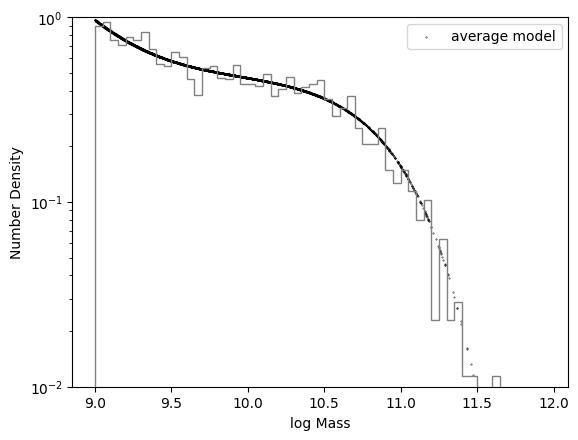

In [16]:
alpha0= np.average(sampler.chain[:,-1,0])
alpha1= np.average(sampler.chain[:,-1,1])
logmstar0= np.average(sampler.chain[:,-1,2])
logphistar0= np.average(sampler.chain[:,-1,3])
logphistar1= np.average(sampler.chain[:,-1,4])

parvals = [alpha0,alpha1,logmstar0,logphistar0,logphistar1]
print(parvals)

args=[logM,dlogM]

avg_model = lnlike_2model( parvals, *args, return_model=True )

plt.clf()
plt.scatter( logM, avg_model, .1 , 'black', label='average model')

plt.hist( logM, bins=np.arange( 9, 12, .05 ), density=True, histtype='step', color='grey' )

plt.ylabel('Number Density')
plt.xlabel('log Mass')

plt.legend()

plt.yscale('log')
plt.ylim( 1e-2, 1 )

In [40]:
print(max(sampler.chain[ :, -1,0 ]))

-0.5989805506775139


In [42]:
nwalkers_f = 200
## initialize the sampler
sampler_f = emcee.EnsembleSampler(nwalkers_f, ndim, lnlike_2model, args=[logM,dlogM])

In [49]:
# Extract the required steps
last_coords = sampler.chain[:, -1, :]  # Last step
last_5th_step_coords = sampler.chain[:, -5, :]  # Last 5th step
last_10th_step_coords = sampler.chain[:, -10, :]  # Last 10th step
last_15th_step_coords = sampler.chain[:, -15, :]  # Last 15th step

# Combine these coordinates into a new array for 200 walkers
initial_positions = np.zeros((200, ndim))

initial_positions[:50] = last_coords
initial_positions[50:100] = last_5th_step_coords
initial_positions[100:150] = last_10th_step_coords
initial_positions[150:200] = last_15th_step_coords

In [58]:
state_f = sampler_f.run_mcmc(initial_positions, 2000, progress=True)

100%|██████████| 2000/2000 [1:08:38<00:00,  2.06s/it]


In [17]:
print(10**np.average(sampler_f.chain[:,-1,4]))

NameError: name 'sampler_f' is not defined